# Problema de Duración de viaje en Taxi

*target*: duracion del viaje  
Problema de **Regresion**

In [1]:
import scipy.io as sio
import scipy as sp
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold , metrics, tree
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering as hac
from sklearn.tree import DecisionTreeClassifier as Tree

from subprocess import check_call
from IPython.display import Image as PImage

In [2]:
def rmsle(predicted,real):
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

def rmse(predicted,real):
    suma=0.0
    for x in range(len(predicted)):
        p = predicted[x]
        r = real[x]
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

def mse(predicted,real):
    suma=0.0
    for x in range(len(predicted)):
        p = predicted[x]
        r = real[x]
        suma += np.power((p - r),2)
    return suma/len(predicted)


In [35]:
#annadir grafico de real vs predecido
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.') #o punto
    
    valor = int( np.max( [np.max(predecido),np.max(real)])+1)
    plt.plot(range(valor), color ="r")
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.title("Compara Valor real con la prediccion")
    plt.show()

In [3]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134

para ver la cantidad de memoria de cada dataset

In [4]:
print("Dimensiones training set: ", df.shape)
print("Dimensiones test set: ", df_test.shape)
df.head()

('Dimensiones training set: ', (1458644, 11))
('Dimensiones test set: ', (625134, 9))


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [8]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


## Visualizar estadisticas

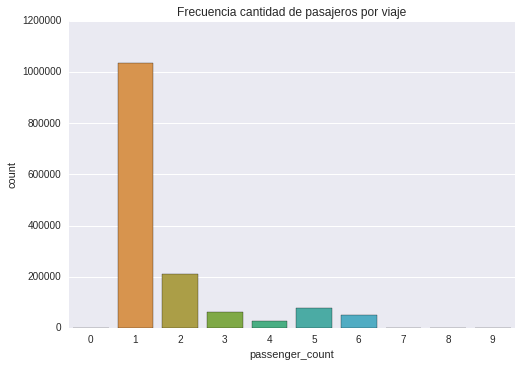

In [12]:
sns.countplot(x='passenger_count',data =df)#hue='store_and_fwd_flag')
plt.title('Frecuencia cantidad de pasajeros por viaje')
plt.show()

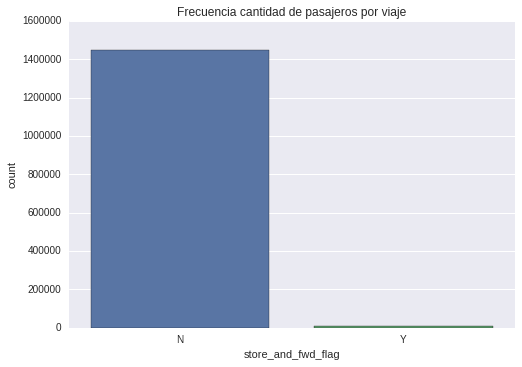

In [13]:
sns.countplot(x='store_and_fwd_flag',data =df)#hue='PTS_TYPE')
plt.title('Frecuencia cantidad de pasajeros por viaje')
plt.show()

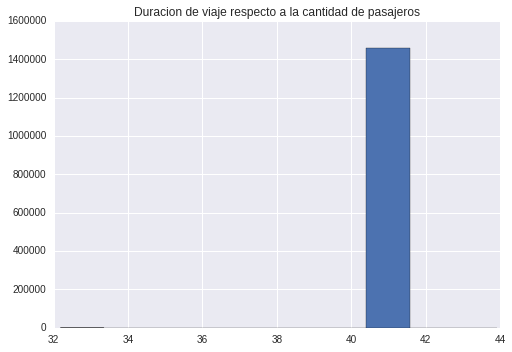

In [14]:
plt.hist(df['_latitude'])#hue='store_and_fwd_flag')
plt.title('Duracion de viaje respecto a la cantidad de pasajeros')
plt.show()

### Analisis de la etiqueta

Valor minimo de duracion:  1
Valor maximo de duracion:  3526282


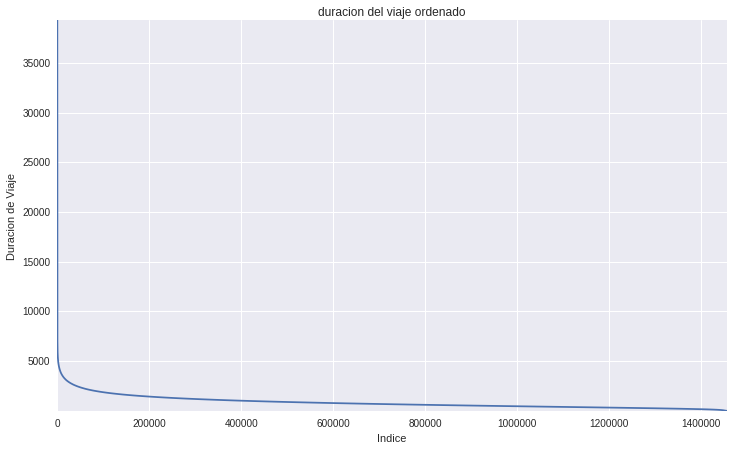

In [48]:
aux = np.sort(df['trip_duration'].values)[::-1]
print "Valor minimo de duracion: ", np.min(aux)
print "Valor maximo de duracion: ", np.max(aux)

plt.figure(figsize=(12,7))
plt.title("duracion del viaje ordenado")
plt.plot(aux[2000:])
plt.ylabel("Duracion de Viaje")
plt.xlabel("Indice")
plt.axis('tight')
plt.show()

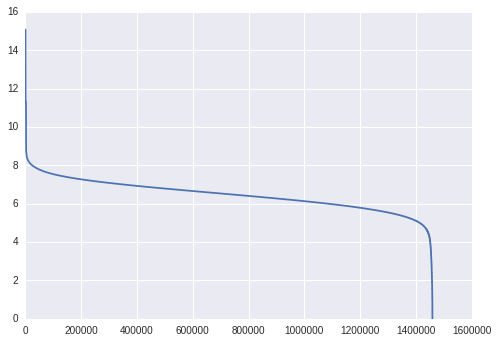

In [51]:
plt.plot(np.log(aux))
plt.show()

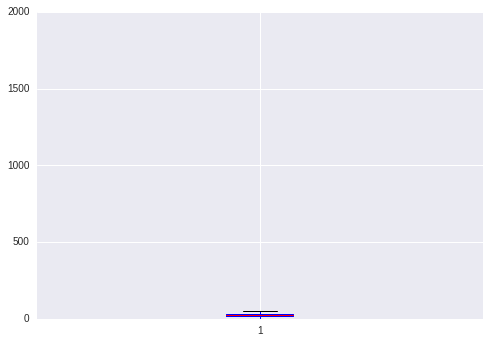

In [41]:
plt.boxplot(np.sqrt(df['trip_duration'].values))
fig.tight_layout()
plt.show()

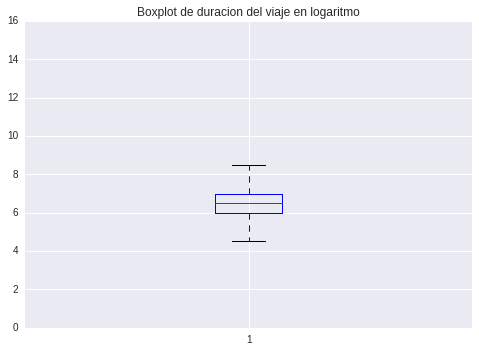

In [19]:
plt.boxplot(np.log(df['trip_duration'].values))
plt.title("Boxplot de duracion del viaje en logaritmo")
plt.show()

Valor minimo de longitud:  -121.93334198
Valor maximo de longitud:  -61.3355293274
Valor minimo de latitude:  32.1811408997
Valor maximo de latitude:  51.8810844421


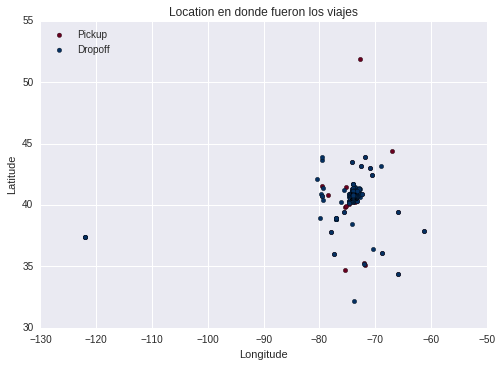

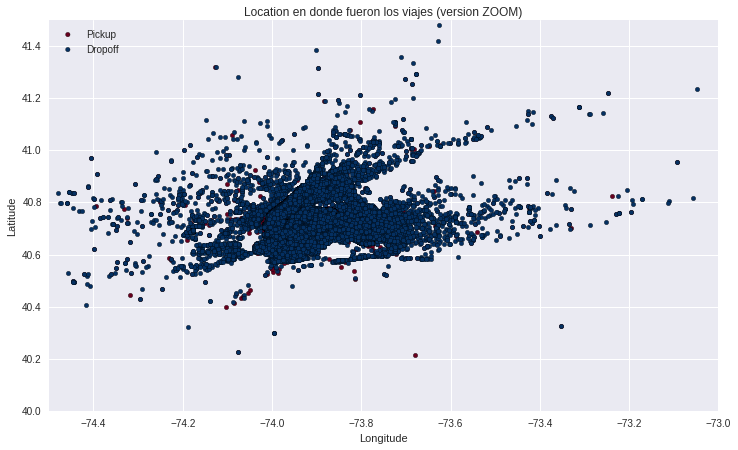

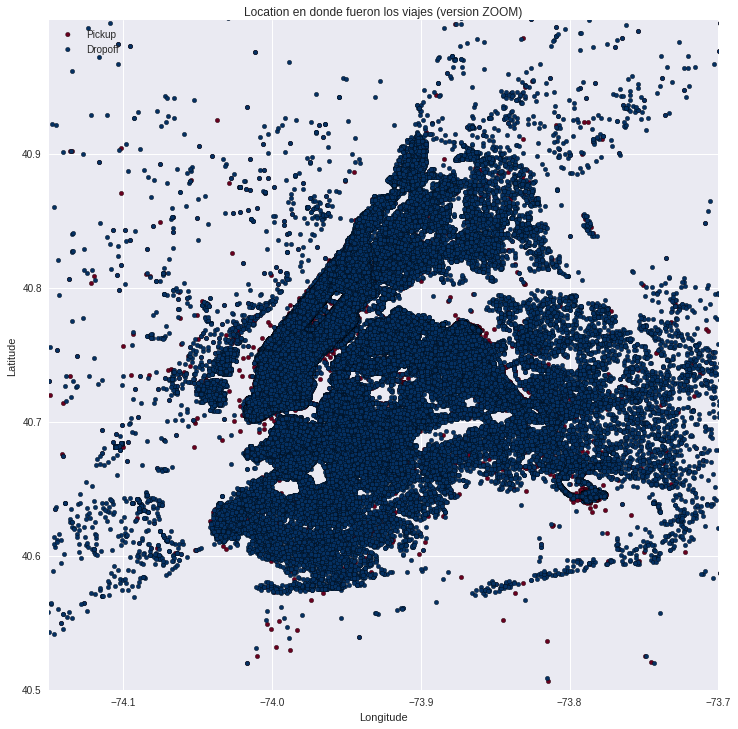

In [58]:
x1,x2 = df['pickup_longitude'].values, df['pickup_latitude'].values
y1,y2 = df['dropoff_longitude'].values, df['dropoff_latitude'].values

print "Valor minimo de longitud: ", np.min([x1,y1]) 
print "Valor maximo de longitud: ", np.max([x1,y1]) 
print "Valor minimo de latitude: ", np.min([x2,y2]) 
print "Valor maximo de latitude: ", np.max([x2,y2]) 

tipos = [0,1]
cmap = plt.cm.get_cmap(name = "RdBu") 
mcolors = [cmap(i) for i in np.linspace(0,1,2)]

plt.scatter(x1,x2,s=20,label="Pickup",c=mcolors[0])
plt.scatter(y1,y2,s=20,label="Dropoff",c=mcolors[1])

plt.title('Location en donde fueron los viajes')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper left')
plt.show()

plt.clf()
plt.figure(figsize=(12,7))

plt.scatter(x1,x2,s=20,label="Pickup",c=mcolors[0])
plt.scatter(y1,y2,s=20,label="Dropoff",c=mcolors[1])

plt.xlim(-74.5,-73)
plt.ylim(40,41.5)

plt.title('Location en donde fueron los viajes (version ZOOM)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper left')
plt.show()

plt.clf()
plt.figure(figsize=(12,12))

plt.scatter(x1,x2,s=20,label="Pickup",c=mcolors[0])
plt.scatter(y1,y2,s=20,label="Dropoff",c=mcolors[1])

plt.xlim(-74.15,-73.7)
plt.ylim(40.5,41)

plt.title('Location en donde fueron los viajes (version ZOOM)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper left')
plt.show()

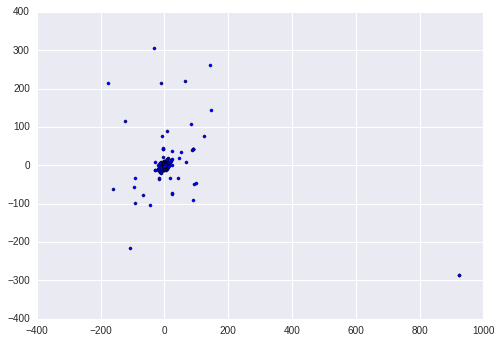

In [32]:
caract = df.ix[:,["passenger_count","pickup_longitude","pickup_latitude","dropoff_longitude",
                  "dropoff_latitude","trip_duration"]].values

#escalar
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(caract)
escalado = scaler.fit_transform(caract)

#model = manifold.TSNE(n_components = 2)
model = PCA(n_components = 2)
#model = manifold.SpectralEmbedding(n_components=2)

x2d = model.fit_transform(escalado)

plt.scatter(x2d[:,0],x2d[:,1],s=20)
plt.legend(loc='upper left')
plt.show()

Conclusion: La mayoría de los viajes duran lo mismo y son el mismo sector... teniendo una gran cantidad de outliers que podrian afectar la precision del algoritmo, por lo que se necesitara un algoritmo robusto a esto, o aplicar una transformacion , como logaritmica.

### Preprocesar dataset

In [60]:
from geopy.distance import great_circle
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all

In [79]:
#reemplazar Nan

def preprocesar(df):
    df.fillna(0,inplace=True)

    df["store_and_fwd_flag"] = df["store_and_fwd_flag"].astype('category')

    #codifica
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

    #transformar fechas a tiempos
    #columna_pickup_dt = df['pickup_datetime'].values
    #columna_dropoff_dt = df['dropoff_datetime'].values

    #procesamiento
    #probar con sumar los segundos
    df['min'] = pd.to_datetime(df['pickup_datetime']).dt.minute
    df['min'] = pd.to_numeric(df['min'])

    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])

    #procesamiento de fecha(datetime-timestamp) a numeros
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek#0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])

    df['year'] = pd.to_datetime(df['pickup_datetime']).dt.year
    df['year'] = pd.to_numeric(df['year'])

    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])

    #caract agregada:
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude']))

    nueva_distancia = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km']=nueva_distancia

    #agregar direccion (en base a grado)

    #viajes largos
    df['tipo_viaje'] = np.mean(df['distancia_viaje']) < df['distancia_viaje']

    #agregar temporada
preprocesar(df)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,min,hour,cday,year,month,distancia_viaje,distancia_viaje_km,tipo_viaje
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,24,17,0,2016,3,0.017680,1.498943,False
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,43,0,6,2016,6,0.020456,1.806016,False
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,35,11,1,2016,1,0.059934,6.386897,True
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,32,19,2,2016,4,0.013438,1.485917,False
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,30,13,5,2016,3,0.010690,1.188923,False


In [63]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,min,hour,cday,year,month,distancia_viaje,distancia_viaje_km
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644.0,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,5.515396e-03,9.594923e+02,2.959016e+01,1.360648e+01,3.050375e+00,2016.0,3.516818e+00,3.548232e-02,3.441833e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,7.406066e-02,5.237432e+03,1.732471e+01,6.399693e+00,1.954039e+00,0.0,1.681038e+00,4.596807e-02,4.297749e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2016.0,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,0.000000e+00,3.970000e+02,1.500000e+01,9.000000e+00,1.000000e+00,2016.0,2.000000e+00,1.258443e-02,1.232184e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,0.000000e+00,6.620000e+02,3.000000e+01,1.400000e+01,3.000000e+00,2016.0,4.000000e+00,2.121671e-02,2.094307e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,0.000000e+00,1.075000e+03,4.500000e+01,1.900000e+01,5.000000e+00,2016.0,5.000000e+00,3.840884e-02,3.876429e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.000000e+00,3.526282e+06,5.900000e+01,2.300000e+01,6.000000e+00,2016.0,6.000000e+00,1.119260e+01,1.241258e+03


### Visualizacion respecto a la hora+fecha

In [72]:
print set(df.month) #solo la primera mitad del anno... (revisar test set igual)
print set(df.year) #revisar test set... (esta caract se ppodria eliminar ya que nos e aprendera nada de tiempos futuros)

set([1, 2, 3, 4, 5, 6])
set([2016])


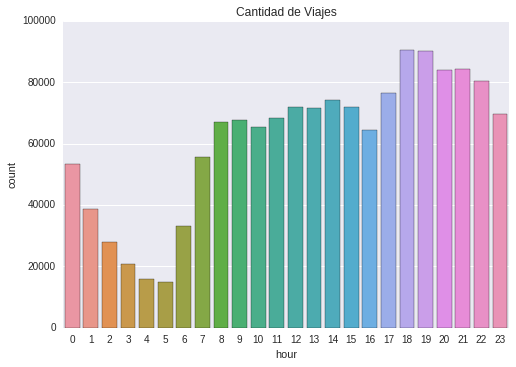

In [11]:
sns.countplot(x='hour',data =df)#, hue='passenger_count')
#sns.countplot(x='cday',data =df)#, hue='passenger_count')
#sns.countplot(x='month',data =df)#, hue='passenger_count')
plt.title("Cantidad de Viajes")
plt.show()

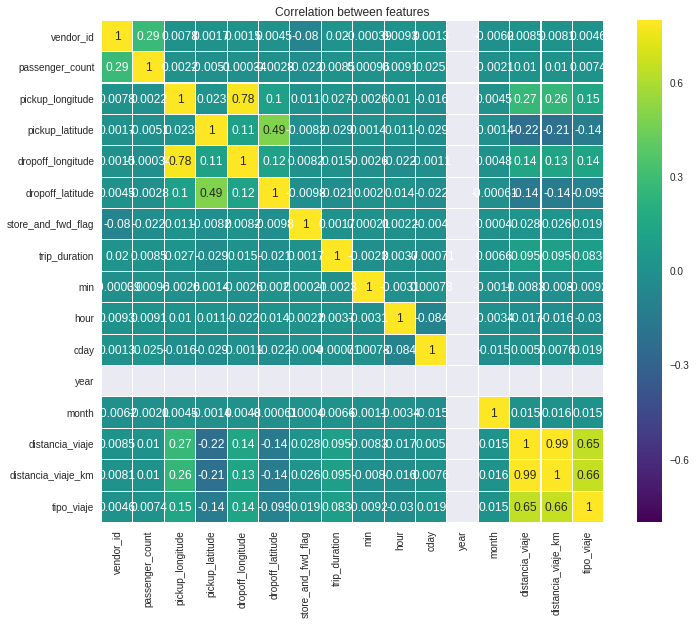

In [64]:
plt.figure(figsize=(12,9))
sns.heatmap(df.corr(), vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
sns.set(font_scale=1)
plt.title('Correlation between features');
plt.show()

es poco el tiempo en el cual se tiene el dataset, por lo que es posible que el tiempo no ayude mucho en predecir la etiqueta, por lo que pienso que fuertemente pueda depender de la posicion y respecto a la HORA.

**Idea para crear nuevas caract puede ser ver las cosas Iportantes que hay alrededor del pickup location** (habria que mirar un mapa)

>> DEFINIR UN CRITERIO HUMANO PARA CUANDO UN VIAJE ES "lARGO" ASI TOMARLO DISTINTO AL RESTO... si el viaje dura mas de 1 hora es largo.. etc

> agregar la temporada en base a la fecha?.. agregar si dia llovio? (trampa?)

In [65]:
#dataset.drop('CLOSEST_DEFENDER_PLAYER_ID',axis=1,inplace=True)
"""
features = ["id", "vendor_id","pickup_datetime","dropoff_datetime","passenger_count",
            "pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude",
            "store_and_fwd_flag","trip_duration","min","hour","cday","year","month"]
"""

features = ["pickup_longitude","pickup_latitude","dropoff_longitude"
            ,"dropoff_latitude","hour","cday","month","distancia_viaje","tipo_viaje"]

#ver que quitar... y sacarlo

X = df.ix[:,features].values
Y = df.ix[:,'trip_duration'].values

#Y = target[:,1] #saca el id
#X = df_X[:,1:] #saca el id

print Y
print X
print X.shape

[ 455  663 2124 ...,  764  373  198]
[[-73.98215484619139 40.76793670654297 -73.96463012695312 ..., 3
  0.017679539499584833 False]
 [-73.98041534423827 40.738563537597656 -73.99948120117188 ..., 6
  0.02045590389170773 False]
 [-73.97902679443358 40.763938903808594 -74.00533294677734 ..., 1
  0.059933799406913624 True]
 ..., 
 [-73.9591293334961 40.768798828125 -74.00443267822266 ..., 4
  0.0763269338814093 True]
 [-73.9820785522461 40.749061584472656 -73.97463226318358 ..., 1
  0.010962317640912801 False]
 [-73.9795379638672 40.7817497253418 -73.97280883789062 ..., 4
  0.011105652354440096 False]]
(1458644, 9)


In [ ]:
#hacer algo aca...



### Crear conjunto de validacion

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)
print "Tamaño de dataset de entrenamiento: ",X_train.shape
print "Tamaño de dataset de validacion: ",X_val.shape

Tamaño de dataset de entrenamiento:  (1021050, 9)
Tamaño de dataset de validacion:  (437594, 9)


In [67]:
def transformar(valor):
    return np.log(valor+1)
def destransformar(valor):
    return np.exp(valor) -1

In [24]:
from sklearn.tree import DecisionTreeRegressor as Tree
model = Tree(max_depth=15)
model.fit(X_train,transformar(y_train))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train)),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val)),y_val)

ERROR RMSLE de training:  0.508286248301
ERROR RMSLE de validacion:  0.535059998233


In [25]:
plt.figure(figsize=(14,6))
plt.bar(range(len(features)), model.feature_importances_)
plt.xticks(range(len(features)),features, rotation= 45)
plt.title('Feature Importance')
plt.show()

ValueError: incompatible sizes: argument 'height' must be length 8 or scalar

In [46]:
tree.export_graphviz(model,  out_file='tree.dot',
                    feature_names = features,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )

#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])

plt.figure(figsize=(12,12))
PImage(filename='tree.png')

KeyboardInterrupt: 

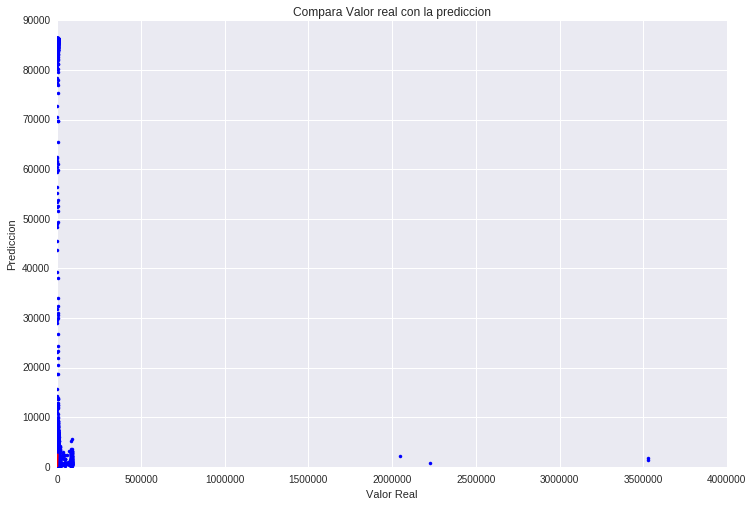

In [22]:
graficar_predicciones(model.predict(X_val),y_val)

### -> Random Forest

In [68]:
from sklearn.ensemble import RandomForestRegressor as RE
model = RE(max_depth=15)
model.fit(X_train,transformar(y_train))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train)),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val)),y_val)

#model.fit(X_train,y_train)

#print "ERROR RMSLE de training: ", rmsle(model.predict(X_train),y_train)
#print "ERROR RMSLE de validacion: ", rmsle(model.predict(X_val),y_val)


ERROR RMSLE de training:  0.377871266383
ERROR RMSLE de validacion:  0.425803588983


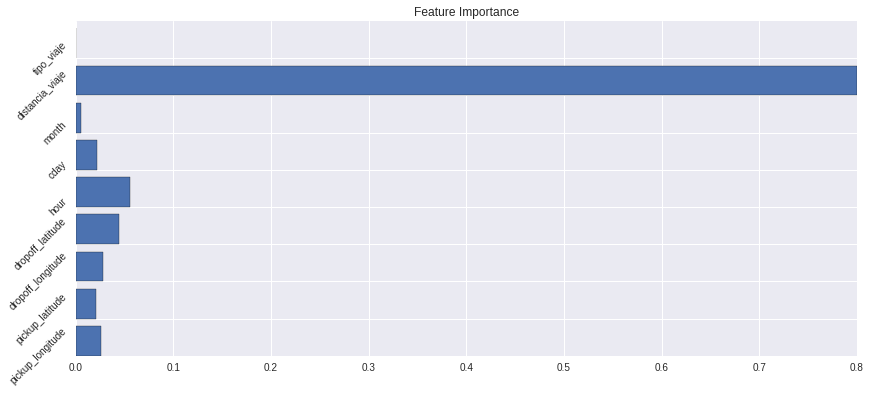

In [73]:
plt.figure(figsize=(14,6))
plt.barh(range(len(features)), model.feature_importances_)
plt.yticks(range(len(features)),features, rotation= 45)
plt.title('Feature Importance')
plt.show()

In [77]:
print destransformar(model.predict(X_val))
print y_val

[ 713.4617192   709.72888828  346.47956273 ...,  359.41294769  856.03223868
  933.64110827]
[1040  827  614 ...,  478 1139 1062]


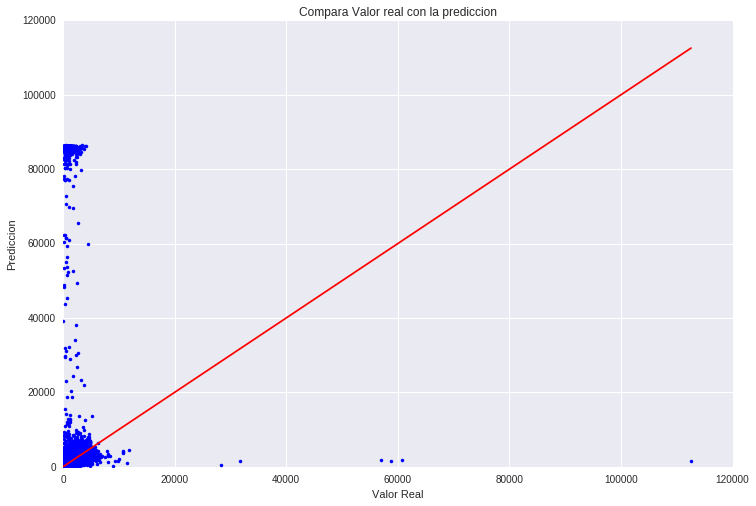

In [78]:
graficar_predicciones(destransformar(model.predict(X_val)),y_val)

In [26]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train,transformar(y_train))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train)),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val)),y_val)

ERROR RMSLE de training:  0.372681292825
ERROR RMSLE de validacion:  0.533950055645


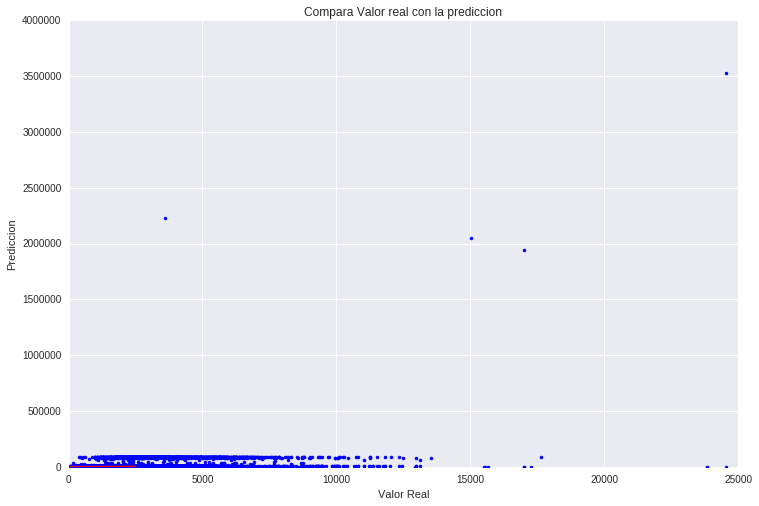

In [13]:
graficar_predicciones(destransformar(model.predict(X_train)),y_train)

In [55]:
#escalar
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

In [ ]:
from sklearn.svm import SVR
model = SVR()
model.fit(X_train,transformar(y_train))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train)),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val)),y_val)

In [ ]:
#probar red neuronal

#### Codigo para hacer la entrega:

In [80]:
preprocesar(df_test)

#cargar caract con las que se entreno el modelo
X_test = df_test.ix[:,features].values

In [91]:
ids_test = df_test.id
target_test = destransformar(model.predict(X_test))


d = {'id': ids_test, 'trip_duration': target_test}

entrega = pd.DataFrame(data=d)
#redondear a entero
entrega['trip_duration'] = entrega.trip_duration.round(0).astype(int)
entrega.head()

,id,trip_duration
0,id3004672,746
1,id3505355,653
2,id1217141,429
3,id2150126,1046
4,id1598245,377


In [93]:
entrega.to_csv('MiprimeraEntrega.csv', index=False)